In [1]:
from utils.augmentation import Cutout_jitter_aug
import torch
import pandas as pd
import numpy as np
from scipy.signal.windows import gaussian
from scipy.stats import beta
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import math
import pickle
from sklearn.neighbors import KernelDensity

In [3]:
# CLDG
seen_MAPE= [0.1215, 0.1146, 0.1183]
unseen_MAPE = [0.1671, 0.1706, 0.1744]
seen_alpha_acc = [0.750864, 0.749012, 0.747778]
unseen_alpha_acc = [0.66, 0.637013, 0.612208]
print('CLDG')
print(f'Seen MAPE: {np.mean(seen_MAPE)}±{np.std(seen_MAPE)}')
print(f'Unseen MAPE: {np.mean(unseen_MAPE)}±{np.std(unseen_MAPE)}')
print(f'Seen 15%-Acc: {np.mean(seen_alpha_acc)}±{np.std(seen_alpha_acc)}')
print(f'Unseen 15%-Acc: {np.mean(unseen_alpha_acc)}±{np.std(unseen_alpha_acc)}')

# w/o CLDG
seen_MAPE= [0.1191, 0.1241, 0.1244]
unseen_MAPE = [0.1929, 0.1861, 0.1801]
seen_alpha_acc = [0.74716, 0.728889, 0.727778]
unseen_alpha_acc = [0.55259, 0.616494, 0.620779]
print('w/o CLDG')
print(f'Seen MAPE: {np.mean(seen_MAPE)}±{np.std(seen_MAPE)}')
print(f'Unseen MAPE: {np.mean(unseen_MAPE)}±{np.std(unseen_MAPE)}')
print(f'Seen 15%-Acc: {np.mean(seen_alpha_acc)}±{np.std(seen_alpha_acc)}')
print(f'Unseen 15%-Acc: {np.mean(unseen_alpha_acc)}±{np.std(unseen_alpha_acc)}')

CLDG
Seen MAPE: 0.11813333333333333±0.002819377393838735
Unseen MAPE: 0.1707±0.002981051268708183
Seen 15%-Acc: 0.7492179999999999±0.0012682470842334261
Unseen 15%-Acc: 0.6364070000000001±0.019515707229477174
w/o CLDG
Seen MAPE: 0.12253333333333333±0.002430820620467272
Unseen MAPE: 0.18636666666666668±0.005228979080300678
Seen 15%-Acc: 0.7346090000000002±0.00888647965544663
Unseen 15%-Acc: 0.596621±0.03118372467596944


In [187]:
%matplotlib inline

In [188]:
def gaussian_kernel(kernel_size: int, sigma: float) -> torch.Tensor:
    """Creates a 1D Gaussian kernel."""
    x = torch.arange(kernel_size, dtype=torch.float32) - (kernel_size - 1) / 2.0
    g = torch.exp(-x.pow(2) / (2 * sigma ** 2))
    print(g)
    return g / g.sum()

def gaussian_blur_1d(x: torch.Tensor, kernel_size: int, sigma: float) -> torch.Tensor:
    """
    Apply Gaussian blur along the sequence dimension (L) of a tensor [B, L, D].
    
    Args:
        x: Input tensor of shape [Batch, Sequence Length, Features].
        kernel_size: Size of the Gaussian kernel (must be odd).
        sigma: Standard deviation of the Gaussian kernel.
    
    Returns:
        Blurred tensor of the same shape [B, L, D].
    """
    B, L, D = x.shape
    kernel = gaussian_kernel(kernel_size, sigma).to(x.device).to(x.dtype)
    kernel = kernel.view(1, 1, -1).expand(D, 1, -1)
    padding = (kernel_size - 1) // 2

    # Permute to [B, D, L]
    x_permuted = x.permute(0, 2, 1)

    # Apply manual replicate padding
    x_padded = F.pad(x_permuted, (padding, padding), mode='replicate')

    # Convolve with padding=0 (no automatic padding)
    x_blurred = F.conv1d(
        x_padded, 
        kernel, 
        padding=0,  # No padding here since we already padded
        groups=D
    )

    return x_blurred.permute(0, 2, 1)

def add_gaussian_noise(X: torch.Tensor, sigma: float = 0.1) -> torch.Tensor:
    """
    Adds Gaussian noise to input tensor.
    
    Args:
        X: Input tensor of shape [Batch, Sequence Length, Features]
        sigma: Standard deviation of the Gaussian noise (controls noise magnitude)
    
    Returns:
        Noisy tensor with same shape as input [B, L, D]
    """
    # Generate Gaussian noise with same shape as X
    noise = torch.randn_like(X) * sigma
    
    # Add noise to original tensor
    X_noisy = X + noise
    
    return X_noisy

In [189]:
data = pickle.load(open('/data/trf/python_works/BatteryLife/dataset/HUST/HUST_1-3.pkl', 'rb'))
data2 = pickle.load(open('/data/trf/python_works/BatteryLife/dataset/HNEI/HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_a.pkl', 'rb'))
cylce_data = data['cycle_data']
cylce_data2 = data2['cycle_data']

In [190]:
df = pd.DataFrame()
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
sub_cycle_data = cylce_data[10]
for key in need_keys:
    df[key] = sub_cycle_data[key]

df2 = pd.DataFrame()
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
sub_cycle_data = cylce_data2[10]
for key in need_keys:
    df2[key] = sub_cycle_data[key]

df2 = df2.loc[df2['current_in_A']<0]
voltages2 = df2['voltage_in_V'].values
currents2 = df2['current_in_A'].values

In [191]:
df

,current_in_A,voltage_in_V,charge_capacity_in_Ah,discharge_capacity_in_Ah,time_in_s
0,5.49888,2.4953,0.000000,0.000000,0
1,5.49925,2.9368,0.006110,0.000000,4
2,5.49851,3.2263,0.013747,0.000000,9
3,5.49888,3.2967,0.021384,0.000000,14
4,5.49888,3.3351,0.029022,0.000000,19
...,...,...,...,...,...
737,-2.19977,2.2154,1.181924,1.182008,3694
738,-2.19977,2.1537,1.181924,1.185064,3699
739,-2.19959,2.0895,1.181924,1.188119,3704
740,-2.19959,2.0225,1.181924,1.191174,3709


(357,) (357,)


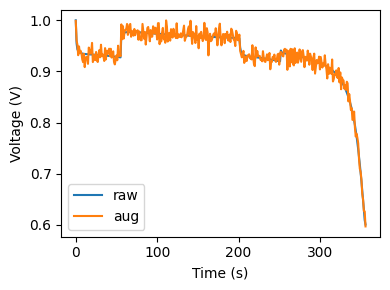

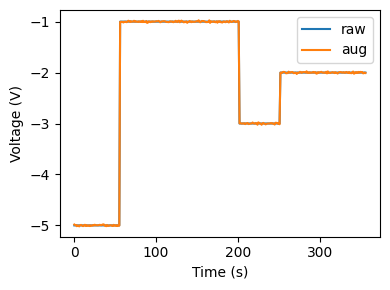

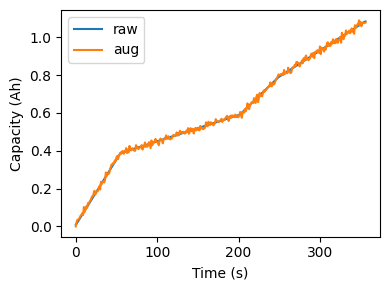

In [192]:
df = df.loc[df['current_in_A']<0]
voltages = df['voltage_in_V'].values
currents = df['current_in_A'].values
capacities = df['discharge_capacity_in_Ah'].values
fig = plt.figure(figsize=(4,3))
voltages = voltages / max(voltages)
plt.plot(np.arange(0,len(voltages)), voltages, label='raw')
X = torch.Tensor(voltages)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
# noise_voltages = gaussian_blur_1d(X, 11, 10)
noise_voltages = add_gaussian_noise(X, 0.01)
noise_voltages = noise_voltages.squeeze(0).squeeze(-1).numpy()
plt.plot(np.arange(0,len(noise_voltages)), noise_voltages, label='aug')
print(noise_voltages.shape, voltages.shape)
plt.legend()
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(4,3))
currents = currents / 1.1
plt.plot(np.arange(0,len(currents)), currents, label='raw')
X = torch.Tensor(currents)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
noise_currents = add_gaussian_noise(X, 0.01)
noise_currents = noise_currents.squeeze(0).squeeze(-1).numpy()
plt.plot(np.arange(0,len(noise_currents)), noise_currents, label='aug')
plt.legend()
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(4,3))
capacities = capacities / 1.1
plt.plot(np.arange(0,len(capacities)), capacities, label='raw')
X = torch.Tensor(capacities)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
noise_capacities = add_gaussian_noise(X, 0.01)
noise_capacities = noise_capacities.squeeze(0).squeeze(-1).numpy()
plt.plot(np.arange(0,len(noise_capacities)), noise_capacities, label='aug')
plt.legend()
plt.ylabel('Capacity (Ah)')
plt.xlabel('Time (s)')
fig.tight_layout()
plt.show()

